In [62]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ast

import seaborn as sns

### Data Preparation

In [4]:
project_root = Path(os.getcwd())

users_path   = project_root / 'movie_users.csv'
df_users     = pd.read_csv(users_path)

conv_path   = project_root / 'movie_conversations.csv'
df_conv     = pd.read_csv(conv_path)

urrs_path   = project_root / 'movie_utterances.csv'
df_utts     = pd.read_csv(urrs_path)


In [5]:
bechd_path   = project_root / 'bechdel_movies_2023_FEB.csv'
df_bechd     = pd.read_csv(bechd_path)

In [6]:
df_temp = df_utts[["utterance_id", "speaker", "reply_to", "movie_id"]]
df_edges_short = df_temp.merge(
    df_temp,
    left_on="reply_to",
    right_on="utterance_id",
    suffixes=('_1', '_2'),
    how='inner'
)

df_edges_short = df_edges_short[["speaker_1", "speaker_2", "movie_id_1"]]
df_edges_short


,speaker_1,speaker_2,movie_id_1
0,u0,u2,m0
1,u0,u2,m0
2,u0,u2,m0
3,u0,u2,m0
4,u2,u0,m0
...,...,...,...
221611,u9030,u9034,m616
221612,u9034,u9030,m616
221613,u9030,u9034,m616
221614,u9034,u9030,m616


In [7]:
df_edges = df_edges_short.merge(
    df_users,
    left_on="speaker_1",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_1', 'character_name':'character_name_1'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1"]]

In [8]:
df_edges = df_edges.merge(
    df_users,
    left_on="speaker_2",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_2', 'character_name':'character_name_2'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1", "gender_2", "character_name_2"]]

In [9]:
cols_to_lower = ['gender_1', 'gender_2']
df_edges[cols_to_lower] = df_edges[cols_to_lower].apply(lambda col: col.str.lower())


In [10]:
df_edges

,speaker_1,speaker_2,movie_id_1,gender_1,character_name_1,gender_2,character_name_2
0,u0,u2,m0,f,BIANCA,m,CAMERON
1,u0,u2,m0,f,BIANCA,m,CAMERON
2,u0,u2,m0,f,BIANCA,m,CAMERON
3,u0,u2,m0,f,BIANCA,m,CAMERON
4,u2,u0,m0,m,CAMERON,f,BIANCA
...,...,...,...,...,...,...,...
221611,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221612,u9034,u9030,m616,?,VEREKER,?,DURNFORD
221613,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221614,u9034,u9030,m616,?,VEREKER,?,DURNFORD


In [11]:
df_meta = df_conv[["movie_idx", "movie_name", "release_year", "genre"]].drop_duplicates()

In [12]:
df_meta['movie_name'] = df_meta['movie_name'].apply(lambda col: col.lower())

df_bechd['title'] = df_bechd['title'].apply(lambda col: col.lower())
df_bechd['title'] = df_bechd['title'].replace(
    r'^(.*),\s*the$',
    r'the \1',
    regex=True
)
df_bechd["title"] = df_bechd["title"].str.replace("&#39;", "'", regex=False)

In [13]:
df_bechd

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
0,passage de venus,1874,0,0.0,3155794,9602,18880,2021-04-02 20:58,1
1,la rosace magique,1877,0,0.0,14495706,9804,19145,2021-05-11 0:11,1
2,sallie gardner at a gallop,1878,0,0.0,2221420,9603,18882,2021-04-03 2:25,1
3,le singe musicien,1878,0,0.0,12592084,9806,19151,2021-05-11 23:38,1
4,athlete swinging a pick,1881,0,0.0,7816420,9816,19162,2021-05-13 1:32,1
...,...,...,...,...,...,...,...,...,...
9897,spider-man: no way home,2021,3,1.0,10872600,10166,19768,2021-12-21 02:14:30,1
9898,timeless,2018,3,0.0,5511582,10165,19766,2021-12-21 00:49:07,1
9899,red notice,2021,1,0.0,7991608,10164,19765,2021-12-20 14:10:11,1
9900,abbott and costello meet frankenstein,1948,3,0.0,40068,10163,19764,2021-12-19 18:11:42,1


In [14]:
df_meta['release_year'] = df_meta['release_year'].str.extract(r'(\d+)', expand=False)
df_meta['release_year'] = df_meta['release_year'].astype('Int64')
df_bechd['year'] = df_bechd['year'].astype('Int64')
df_meta = df_meta.merge(
    df_bechd,
    left_on=["movie_name", "release_year"],
    right_on=["title", "year"],
    how="left",
)

df_meta = df_meta[["movie_idx", "movie_name", "release_year", "genre", "rating"]].drop_duplicates()


In [15]:
df_meta = df_meta.rename(columns={'rating':'bechdel_score'})

In [ ]:
df_meta['genre'] = df_meta['genre'].apply(ast.literal_eval)
df_meta

In [17]:
df_edges = df_edges.rename(columns={'movie_id_1': 'movie_id'})
df_meta = df_meta.rename(columns={'movie_idx': 'movie_id'})
meta_dict = df_meta.set_index('movie_id').to_dict(orient='index')
df_edges = df_edges[df_edges['movie_id'].isin(df_meta['movie_id'])]


df_grouped = (
    df_edges
      .groupby(['movie_id', 'speaker_1', 'speaker_2'])
      .size()
      .reset_index(name='weight')
)


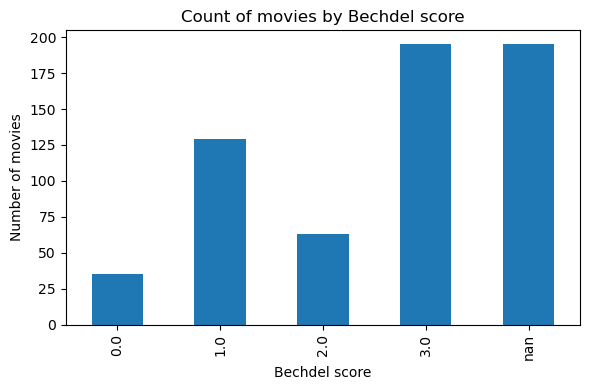

In [18]:
bechdel_counts = (
    df_meta['bechdel_score']
    .value_counts(dropna=False)
    .sort_index()
)

plt.figure(figsize=(6,4))
bechdel_counts.plot(kind='bar')
plt.xlabel('Bechdel score')
plt.ylabel('Number of movies')
plt.title('Count of movies by Bechdel score')
plt.tight_layout()
plt.show()


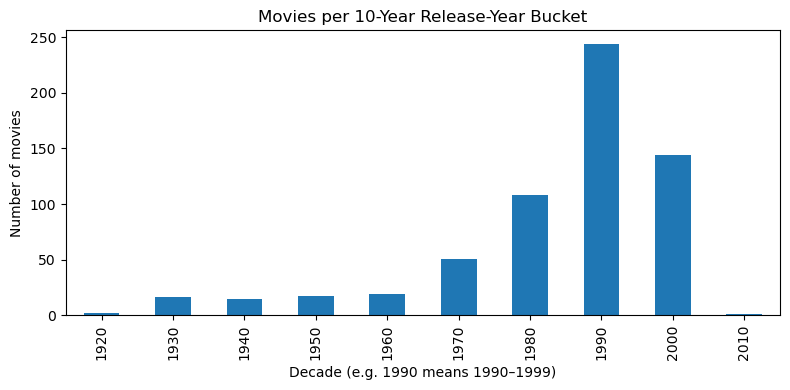

In [19]:
df_year = df_meta.dropna(subset=['release_year']).copy()

df_year['decade'] = (df_year['release_year'] // 10) * 10
decade_counts = df_year['decade'].value_counts().sort_index()

plt.figure(figsize=(8,4))
decade_counts.plot(kind='bar')
plt.xlabel('Decade (e.g. 1990 means 1990–1999)')
plt.ylabel('Number of movies')
plt.title('Movies per 10‐Year Release‐Year Bucket')
plt.tight_layout()
plt.show()

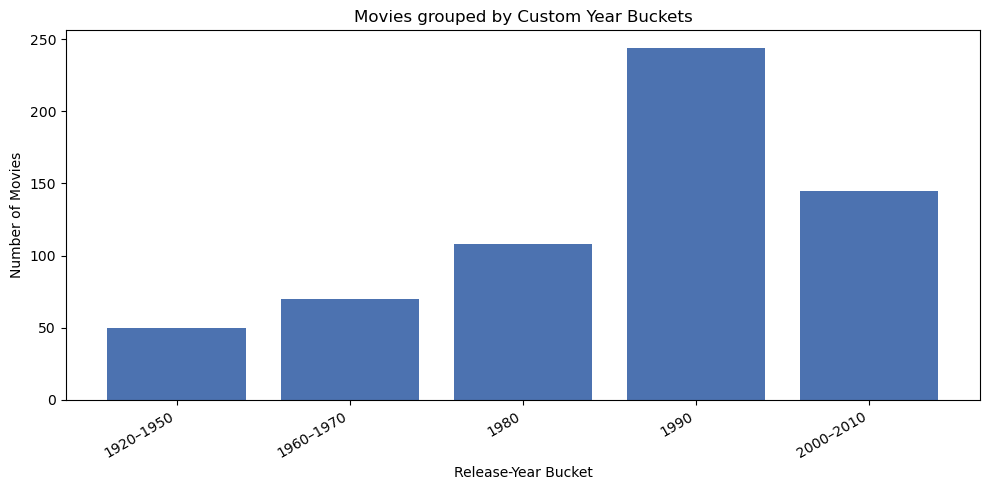

In [20]:
df_year = df_meta.dropna(subset=['release_year']).copy()

def to_custom_bucket(year):
    dec = (int(year) // 10) * 10
    if 1920 <= dec <= 1950:
        return '1920–1950'
    elif 1960 <= dec <= 1970:
        return '1960–1970'
    elif 2000 <= dec <= 2010:
        return '2000–2010'
    else:
        return str(dec)

df_year['bucket'] = df_year['release_year'].apply(to_custom_bucket)

bucket_counts = (
    df_year['bucket']
    .value_counts()
    .reset_index(name='count')
    .rename(columns={'index': 'bucket'})
)

def bucket_sort_key(bucket_label):
    if '–' in bucket_label:
        first_part = bucket_label.split('–')[0]
        return int(first_part)
    else:
        return int(bucket_label)

bucket_counts['sort_key'] = bucket_counts['bucket'].apply(bucket_sort_key)
bucket_counts = bucket_counts.sort_values('sort_key', ascending=True).reset_index(drop=True)
bucket_counts = bucket_counts.drop(columns=['sort_key'])

plt.figure(figsize=(10, 5))
plt.bar(bucket_counts['bucket'], bucket_counts['count'], color='#4C72B0')
plt.xlabel('Release‐Year Bucket')
plt.ylabel('Number of Movies')
plt.title('Movies grouped by Custom Year Buckets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

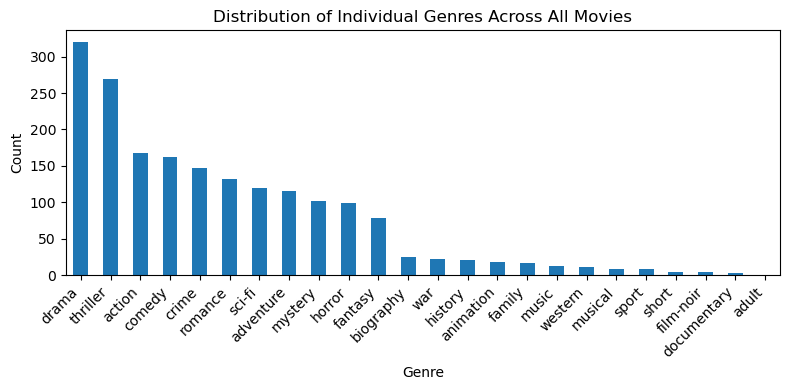

In [21]:
df_exploded = df_meta.explode('genre')
genre_counts = df_exploded['genre'].value_counts()

plt.figure(figsize=(8,4))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Individual Genres Across All Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Graphs Construction and Visualization

In [27]:
df_users['gender'] =  df_users['gender'].astype(str).str.lower()

graphs_by_movie = {}

for mid, sub_df in df_grouped.groupby('movie_id'):
    G = nx.Graph()

    df_this_movie_users = df_users[df_users['movie_idx'] == mid]
    id_to_name   = df_this_movie_users.set_index('user_id')['character_name'].to_dict()
    id_to_gender = df_this_movie_users.set_index('user_id')['gender'].to_dict()

    unique_speakers = set(sub_df['speaker_1']).union(sub_df['speaker_2'])

    for uid in unique_speakers:
        char_name = id_to_name.get(uid, uid)
        gender    = id_to_gender.get(uid, '?')
        G.add_node(uid,
                   character_name=char_name,
                   gender=gender)

    for _, row in sub_df.iterrows():
        u = row['speaker_1']
        v = row['speaker_2']
        w = row['weight']
        if G.has_edge(u, v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    if total_weight > 0:
        for u, v, data in G.edges(data=True):
            data['weight'] = round(data['weight'] / total_weight, 2)

    if mid in meta_dict:
        G.graph['movie_name']   = meta_dict[mid]['movie_name']
        G.graph['release_year'] = meta_dict[mid]['release_year']
        G.graph['genre']        = meta_dict[mid]['genre']
        G.graph['bechdel_score']= meta_dict[mid]['bechdel_score']
    else:
        G.graph['movie_name']   = None
        G.graph['release_year'] = None
        G.graph['genre']        = None
        G.graph['bechdel_score']= None

    graphs_by_movie[mid] = G

In [28]:
def plot_movie_graph_with_node_attrs(movie_id,
                                     node_size=800,
                                     edge_width_factor=15):

    if movie_id not in graphs_by_movie:
        print(f"No graph found for movie_id {movie_id}")
        return

    G = graphs_by_movie[movie_id]
    movie_name = G.graph.get('movie_name', 'Unknown')

    node_colors = []
    labels = {}
    for uid, attrdict in G.nodes(data=True):
        gender = attrdict.get('gender', '?').lower()
        if gender == 'f':
            node_colors.append('#ff69b4')
        elif gender == 'm':
            node_colors.append('#1f77b4')
        else:
            node_colors.append('gray')
        labels[uid] = attrdict.get('character_name', uid)

    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color=node_colors
    )

    widths = []
    for u, v, data in G.edges(data=True):
        w = data.get('weight', 0)
        widths.append(w * edge_width_factor)

    nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color='gray',
        alpha=0.7
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=8
    )
    plt.title(f"Conversation Graph for \"{movie_name}\"", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

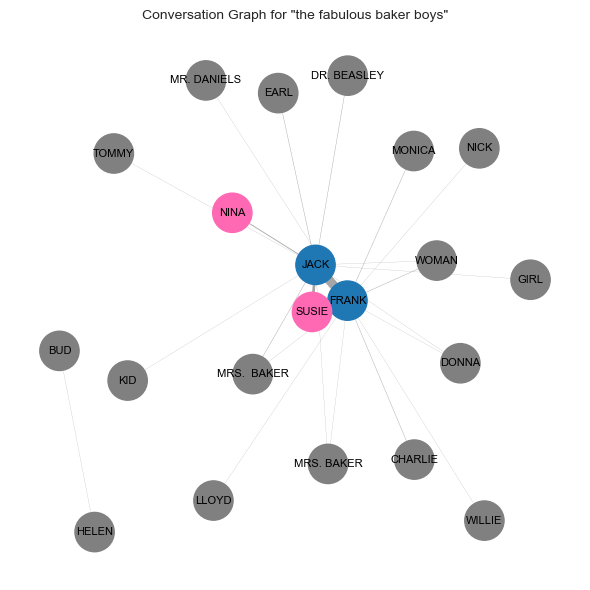

In [172]:
mid = df_conv["movie_idx"].sample(n=1).iloc[0]
plot_movie_graph_with_node_attrs('m342')

In [30]:
node_counts = []
edge_counts = []
known_gender_percents = []

for mid, G in graphs_by_movie.items():
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    node_counts.append(n_nodes)
    edge_counts.append(n_edges)

    n_known = sum(
        1
        for _, attr in G.nodes(data=True)
        if attr.get('gender') not in (None, '?')
    )
    pct_known = (n_known / n_nodes) * 100 if n_nodes > 0 else 0
    known_gender_percents.append(pct_known)

node_counts = np.array(node_counts)
edge_counts = np.array(edge_counts)
known_gender_percents = np.array(known_gender_percents)


avg_nodes              = node_counts.mean()                if node_counts.size > 0              else 0
avg_edges              = edge_counts.mean()                if edge_counts.size > 0              else 0
avg_known_gender_pct   = known_gender_percents.mean()      if known_gender_percents.size > 0    else 0

median_nodes           = np.median(node_counts)            if node_counts.size > 0              else 0
median_edges           = np.median(edge_counts)            if edge_counts.size > 0              else 0
median_known_gender_pct = np.median(known_gender_percents) if known_gender_percents.size > 0    else 0

min_nodes, max_nodes        = (node_counts.min(), node_counts.max())             if node_counts.size > 0           else (0, 0)
min_edges, max_edges        = (edge_counts.min(), edge_counts.max())             if edge_counts.size > 0           else (0, 0)
min_known_pct, max_known_pct = (known_gender_percents.min(), known_gender_percents.max()) if known_gender_percents.size > 0 else (0, 0)


print(f"Computed over {len(graphs_by_movie)} movies:")
print(f"  • Average number of nodes per movie:                  {avg_nodes:.2f}")
print(f"  • Median number of nodes per movie:                   {median_nodes:.0f}")
print(f"  • Min/Max nodes per movie:                            {min_nodes} / {max_nodes}")
print()
print(f"  • Average number of edges per movie:                  {avg_edges:.2f}")
print(f"  • Median number of edges per movie:                   {median_edges:.0f}")
print(f"  • Min/Max edges per movie:                            {min_edges} / {max_edges}")
print()
print(f"  • Average % of nodes with known gender per movie:     {avg_known_gender_pct:.2f}%")
print(f"  • Median % of nodes with known gender per movie:      {median_known_gender_pct:.0f}%")
print(f"  • Min/Max % of nodes with known gender per movie:     {min_known_pct:.0f}% / {max_known_pct:.0f}%")


Computed over 617 movies:
  • Average number of nodes per movie:                  14.64
  • Median number of nodes per movie:                   14
  • Min/Max nodes per movie:                            2 / 44

  • Average number of edges per movie:                  17.26
  • Median number of edges per movie:                   17
  • Min/Max edges per movie:                            1 / 59

  • Average % of nodes with known gender per movie:     35.06%
  • Median % of nodes with known gender per movie:      33%
  • Min/Max % of nodes with known gender per movie:     0% / 86%


In [31]:
df_users_count = (
    df_users[['user_id', 'gender']]
    .drop_duplicates()
    .copy()
)
df_users_count['gender'] = df_users_count['gender'].str.lower()

count_series = df_users_count['gender'].value_counts()
df_counts = (
    count_series
    .rename_axis('gender')
    .reset_index(name='count')
)

total = df_counts['count'].sum()
df_counts['percent'] = (df_counts['count'] / total * 100).round(1)

print(f"Total entries: {total}")
for _, row in df_counts.iterrows():
    gender_code = row['gender']
    gender_label = {
        'f': 'Female',
        'm': 'Male',
        '?': 'Unknown'
    }.get(gender_code, gender_code)

    print(f"  • {gender_label:<7}: {row['count']:>4}  ({row['percent']:>5.1f}%)")


Total entries: 9035
  • Unknown: 6020  ( 66.6%)
  • Male   : 2049  ( 22.7%)
  • Female :  966  ( 10.7%)


### Metrics Calculation

In [46]:
import numpy as np
import pandas as pd
import networkx as nx

def get_max_gender(metric, genders):
    valid_nodes = [n for n in metric if genders.get(n, '?') in {'m', 'f'}]
    if not valid_nodes:
        return None

    sorted_nodes = sorted(valid_nodes, key=lambda k: metric[k], reverse=True)
    top_value = metric[sorted_nodes[0]]
    top_nodes = [n for n in sorted_nodes if metric[n] == top_value]
    top_genders = [genders.get(n, '?') for n in top_nodes]

    if len(set(top_genders)) == 1:
        return top_genders[0]

    # If more than two tied, use majority among them
    if len(top_genders) > 2:
        counts = {'m': top_genders.count('m'), 'f': top_genders.count('f')}
        if counts['m'] > counts['f']:
            return 'm'
        elif counts['f'] > counts['m']:
            return 'f'
        else:
            if len(sorted_nodes) > 2:
                next_best_value = metric[sorted_nodes[2]]
                next_best_nodes = [n for n in sorted_nodes if metric[n] == next_best_value]
                next_best_genders = [genders.get(n, '?') for n in next_best_nodes if genders.get(n, '?') in {'m', 'f'}]
                return next_best_genders[0] if next_best_genders else '?'
            else:
                return '?'

    # If tie between two with different genders, use next best as tiebreak
    elif len(top_genders) == 2:
        if len(sorted_nodes) > 2:
            next_best_value = metric[sorted_nodes[2]]
            next_best_nodes = [n for n in sorted_nodes if metric[n] == next_best_value]
            next_best_genders = [genders.get(n, '?') for n in next_best_nodes if genders.get(n, '?') in {'m', 'f'}]
            return next_best_genders[0] if next_best_genders else '?'
        else:
            return '?'



def calc_graph_metrics(graphs_by_movie, df_meta):
    meta_idx = df_meta.set_index('movie_id')

    records = []

    for movie_id, G in graphs_by_movie.items():
        # Metadata
        meta = meta_idx.loc[movie_id] if movie_id in meta_idx.index else {}
        genres = meta['genre'] if 'genre' in meta else []
        release_year = meta['release_year'] if 'release_year' in meta else None
        bechdel_score = meta['bechdel_score'] if 'bechdel_score' in meta else None
        movie_name = meta['movie_name'] if 'movie_name' in meta else None

        genders = nx.get_node_attributes(G, 'gender')
        all_nodes = list(G.nodes())
        female_nodes = [n for n in all_nodes if genders.get(n, '?') == 'f']
        male_nodes   = [n for n in all_nodes if genders.get(n, '?') == 'm']

        degree = dict(G.degree(weight='weight'))
        unweighted_degree = dict(G.degree())
        betweenness = nx.betweenness_centrality(G, weight='weight')
        closeness = nx.closeness_centrality(G, distance='weight')
        clustering = nx.clustering(G, weight='weight')
        try:
            pagerank = nx.pagerank(G, weight='weight')
        except Exception:
            pagerank = {n: np.nan for n in G.nodes()}

        # Helper statistics
        def avg(metric, group): return np.mean([metric[n] for n in group]) if group else np.nan
        def std(metric, group): return np.std([metric[n] for n in group]) if group else np.nan


        # Centralization
        deg_vals = np.array(list(degree.values()))
        centralization = (
                np.sum(deg_vals.max() - deg_vals) / ((len(deg_vals)-1)*(len(deg_vals)-2))
                if len(deg_vals) > 2 else np.nan
            )

        # Graph-level metrics
        density = nx.density(G)
        try:
            diameter = nx.diameter(G)
        except nx.NetworkXError:
            diameter = np.nan
        try:
            avg_shortest = nx.average_shortest_path_length(G, weight='weight')
        except nx.NetworkXError:
            avg_shortest = np.nan

        # Node/edge/gender statistics
        n_nodes = len(all_nodes)
        n_edges = len(G.edges())
        n_female = len(female_nodes)
        n_male   = len(male_nodes)
        pct_known_gender = 100 * len([n for n in all_nodes if genders.get(n, '?') in {'m','f'}]) / n_nodes if n_nodes else np.nan

        # Results
        row = {
            'movie_id': movie_id,
            'movie_name': movie_name,
            'release_year': release_year,
            'genres': genres,
            'bechdel_score': bechdel_score,

            'n_nodes': n_nodes,
            'n_edges': n_edges,
            'n_female': n_female,
            'n_male': n_male,
            'pct_known_gender': pct_known_gender,

            'density': density,
            'diameter': diameter,
            'avg_shortest_path': avg_shortest,
            'centralization': centralization,

            'degree_all_mean': avg(degree, all_nodes),
            'degree_f_mean': avg(degree, female_nodes),
            'degree_m_mean': avg(degree, male_nodes),
            'degree_all_std': std(degree, all_nodes),
            'degree_f_std': std(degree, female_nodes),
            'degree_m_std': std(degree, male_nodes),

            'unweighted_degree_all_mean': avg(unweighted_degree, all_nodes),
            'unweighted_degree_f_mean': avg(unweighted_degree, female_nodes),
            'unweighted_degree_m_mean': avg(unweighted_degree, male_nodes),
            'unweighted_degree_all_std': std(unweighted_degree, all_nodes),
            'unweighted_degree_f_std': std(unweighted_degree, female_nodes),
            'unweighted_degree_m_std': std(unweighted_degree, male_nodes),

            'betweenness_all_mean': avg(betweenness, all_nodes),
            'betweenness_f_mean': avg(betweenness, female_nodes),
            'betweenness_m_mean': avg(betweenness, male_nodes),
            'betweenness_all_std': std(betweenness, all_nodes),
            'betweenness_f_std': std(betweenness, female_nodes),
            'betweenness_m_std': std(betweenness, male_nodes),

            'closeness_all_mean': avg(closeness, all_nodes),
            'closeness_f_mean': avg(closeness, female_nodes),
            'closeness_m_mean': avg(closeness, male_nodes),
            'closeness_all_std': std(closeness, all_nodes),
            'closeness_f_std': std(closeness, female_nodes),
            'closeness_m_std': std(closeness, male_nodes),

            'clustering_all_mean': avg(clustering, all_nodes),
            'clustering_f_mean': avg(clustering, female_nodes),
            'clustering_m_mean': avg(clustering, male_nodes),
            'clustering_all_std': std(clustering, all_nodes),
            'clustering_f_std': std(clustering, female_nodes),
            'clustering_m_std': std(clustering, male_nodes),

            'pagerank_all_mean': avg(pagerank, all_nodes),
            'pagerank_f_mean': avg(pagerank, female_nodes),
            'pagerank_m_mean': avg(pagerank, male_nodes),
            'pagerank_all_std': std(pagerank, all_nodes),
            'pagerank_f_std': std(pagerank, female_nodes),
            'pagerank_m_std': std(pagerank, male_nodes),


            'top_degree_gender': get_max_gender(degree, genders),
            'top_unw_degree_gender': get_max_gender(unweighted_degree, genders),
            'top_betweenness_gender': get_max_gender(betweenness, genders),
            'top_pagerank_gender': get_max_gender(pagerank, genders),
            'top_closeness_gender': get_max_gender(closeness, genders),
            'top_clustering_gender': get_max_gender(clustering, genders),
        }

        records.append(row)

    return pd.DataFrame(records)


In [47]:
df_metrics = calc_graph_metrics(graphs_by_movie, df_meta)
df_metrics

,movie_id,movie_name,release_year,genres,bechdel_score,n_nodes,n_edges,n_female,n_male,pct_known_gender,...,pagerank_m_mean,pagerank_all_std,pagerank_f_std,pagerank_m_std,top_degree_gender,top_unw_degree_gender,top_betweenness_gender,top_pagerank_gender,top_closeness_gender,top_clustering_gender
0,m0,10 things i hate about you,1999,"[comedy, romance]",3.0,12,19,3,5,66.666667,...,0.102311,0.066800,0.075922,0.049027,f,f,f,f,f,m
1,m1,1492: conquest of paradise,1992,"[adventure, biography, drama, history]",NaN,14,14,0,2,14.285714,...,0.224131,0.083778,NaN,0.142576,m,m,m,m,m,m
2,m10,affliction,1997,"[drama, mystery, thriller]",NaN,16,17,3,5,50.000000,...,0.131786,0.092811,0.020543,0.140738,m,m,m,m,m,m
3,m100,innerspace,1987,"[action, adventure, comedy, crime, sci-fi]",NaN,16,22,1,2,18.750000,...,0.265719,0.085052,0.000000,0.070660,m,m,m,m,m,m
4,m101,the insider,1999,"[biography, drama, thriller]",NaN,27,31,2,4,22.222222,...,0.148576,0.064535,0.007300,0.114111,m,m,m,m,m,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,m95,i am legend,2007,"[drama, sci-fi, thriller]",3.0,5,4,1,1,40.000000,...,0.475677,0.161213,0.000000,0.000000,m,m,m,m,m,?
613,m96,invaders from mars,1953,"[horror, sci-fi]",NaN,6,7,1,2,50.000000,...,0.255579,0.098846,0.000000,0.062006,m,f,f,m,m,m
614,m97,independence day,1996,"[action, adventure, sci-fi, thriller]",3.0,19,18,2,5,36.842105,...,0.082550,0.028421,0.006947,0.031071,m,m,f,m,f,f
615,m98,indiana jones and the last crusade,1989,"[action, adventure, thriller, action, adventur...",0.0,9,11,1,4,55.555556,...,0.196989,0.122592,0.000000,0.141478,m,m,m,m,m,m


### By Year Annalysis

In [48]:
def to_year_bracket(year):
    try:
        year = int(year)
    except (ValueError, TypeError):
        return 'Unknown'
    if 1920 <= year <= 1959:
        return '1920–1950s'
    elif 1960 <= year <= 1979:
        return '1960–1970s'
    elif 1980 <= year <= 1989:
        return '1980s'
    elif 1990 <= year <= 1999:
        return '1990s'
    elif year >= 2000:
        return '2000+'
    else:
        return 'Unknown'

df_metrics['year_bracket'] = df_metrics['release_year'].apply(to_year_bracket)


In [63]:
def male_female_year_comp(metric):
    grouped = (
        df_metrics
        .groupby('year_bracket')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )

    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()


    plt.figure(figsize=(10,5))
    df_long = df_metrics.melt(id_vars=['year_bracket'],
                             value_vars=[f'{metric}_f_mean',f'{metric}_m_mean'],
                             var_name='gender', value_name=f'mean_{metric}')
    df_long['gender'] = df_long['gender'].map({f'{metric}_f_mean':'Female',f'{metric}_m_mean':'Male'})

    year_order = ['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+']

    sns.boxplot(
        x='year_bracket',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=year_order
    )
    plt.xlabel('Year Bracket')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender and Year')
    plt.tight_layout()
    plt.show()


    diff = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    err = np.sqrt(grouped[f'{metric}_m_mean_std']**2 + grouped[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(8,4))
    plt.errorbar(grouped['year_bracket'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Year Bracket')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} Over Time')
    plt.tight_layout()
    plt.show()


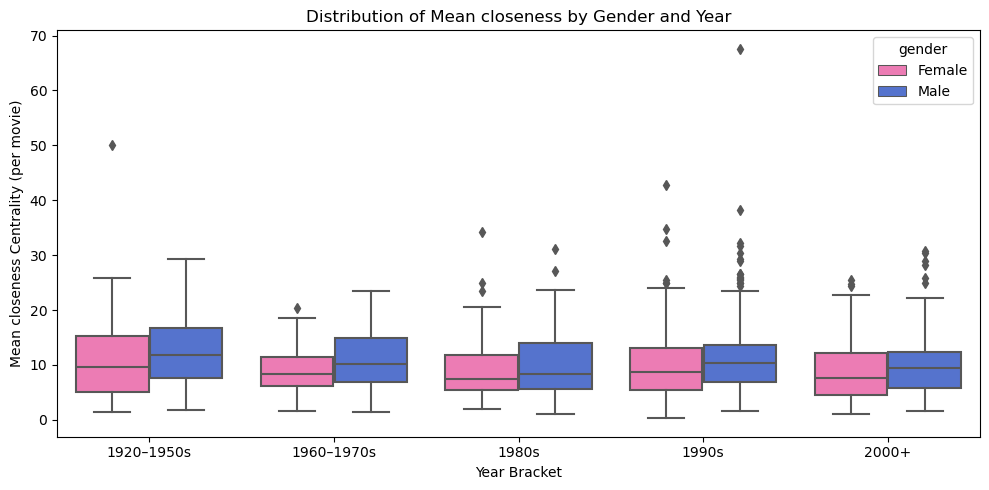

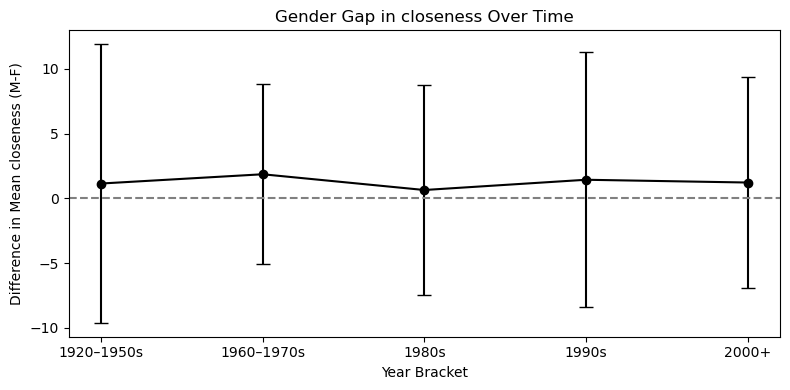

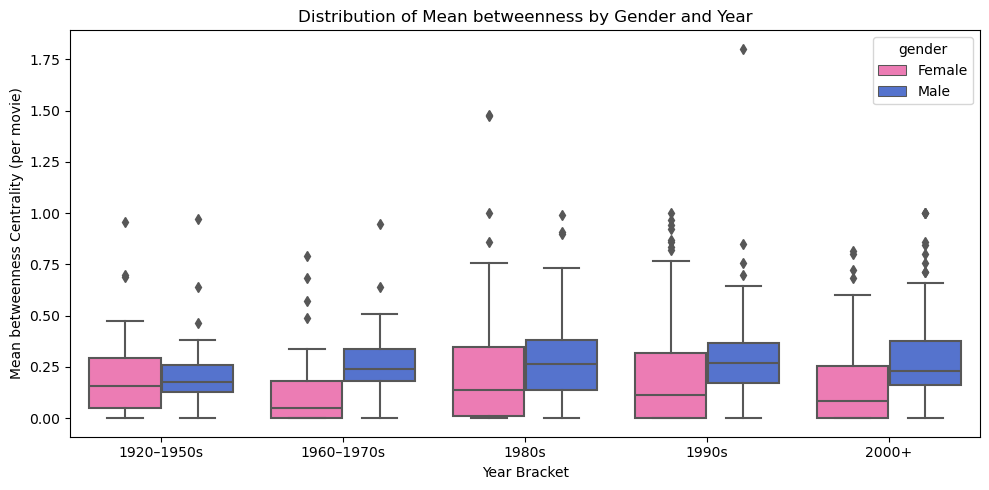

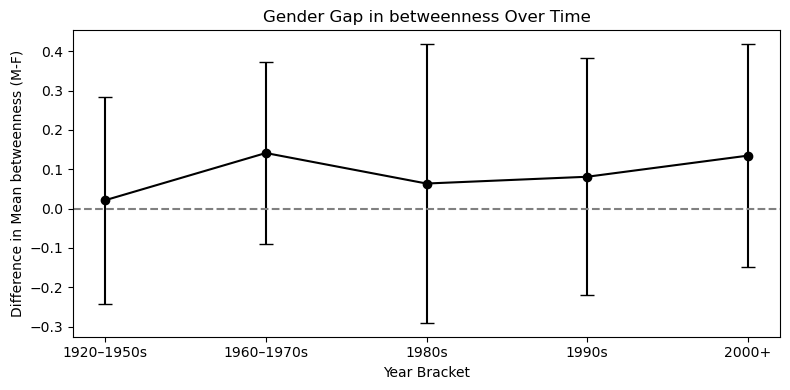

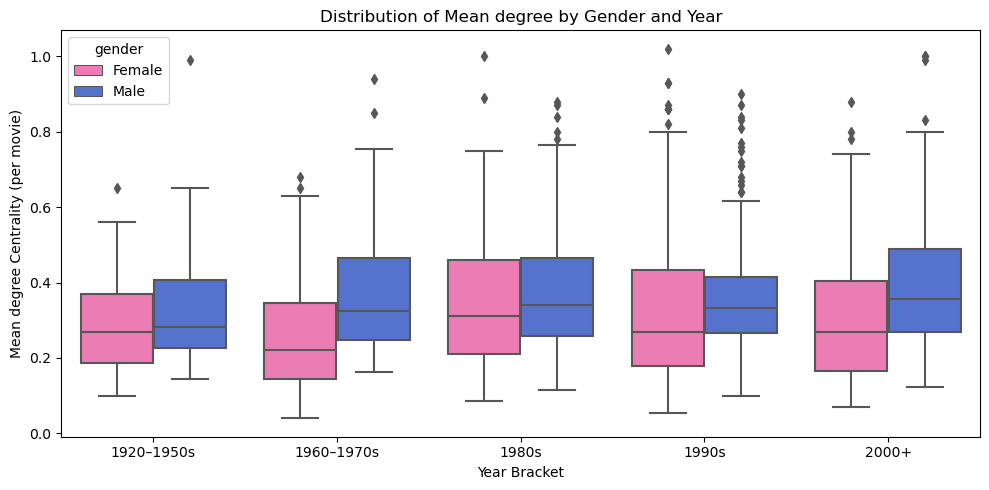

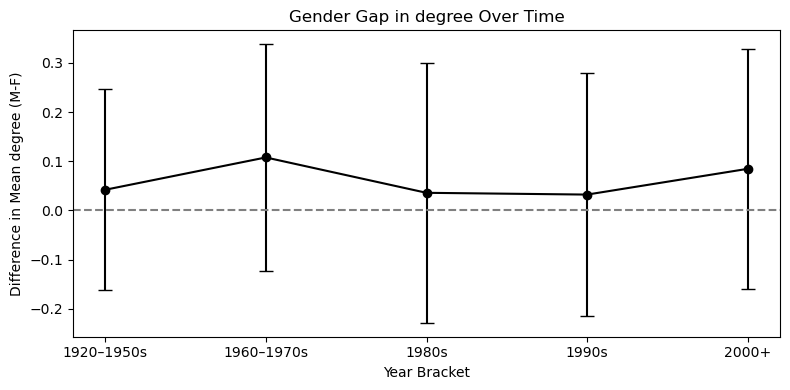

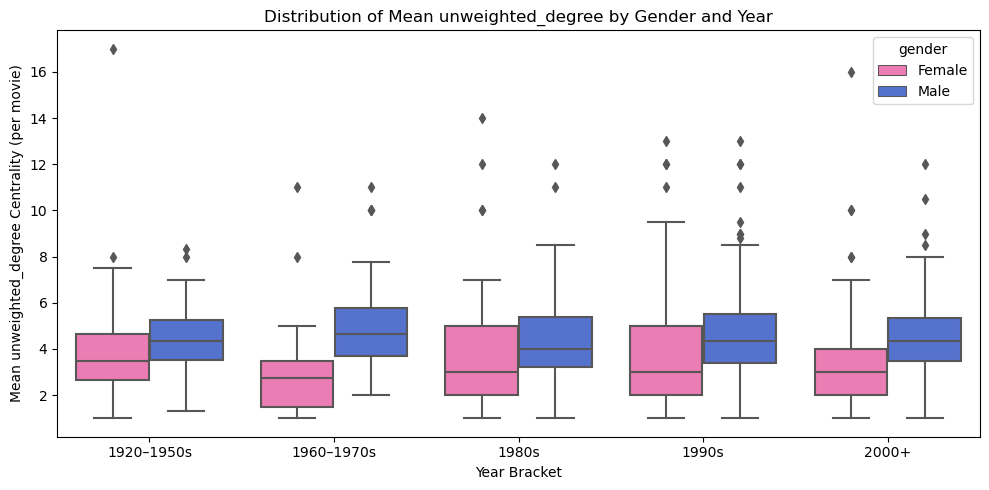

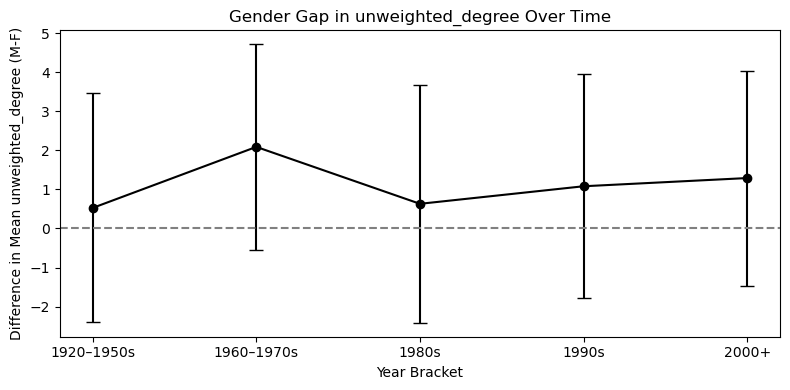

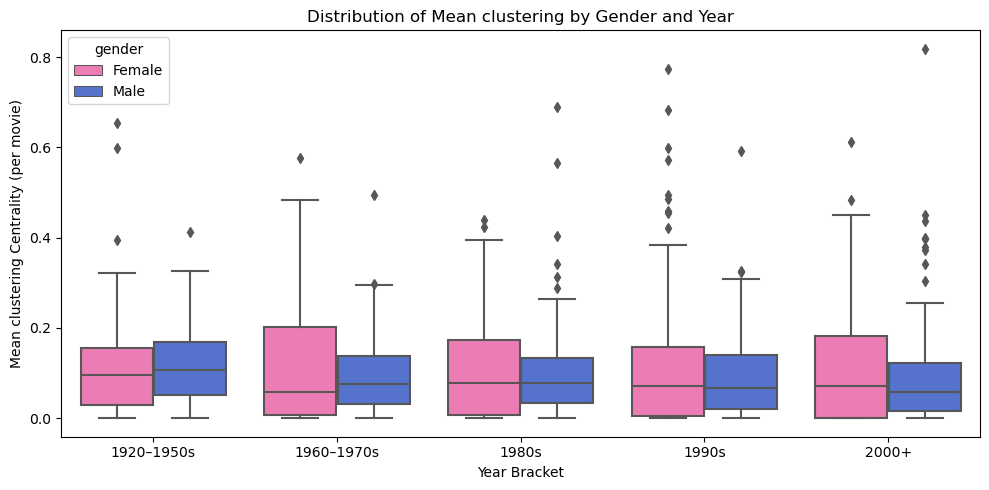

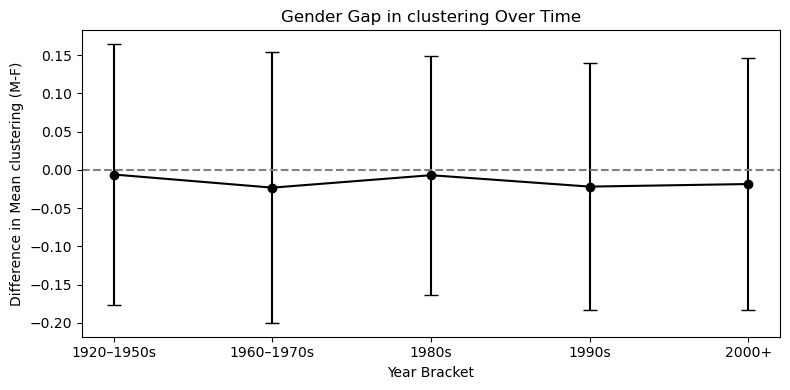

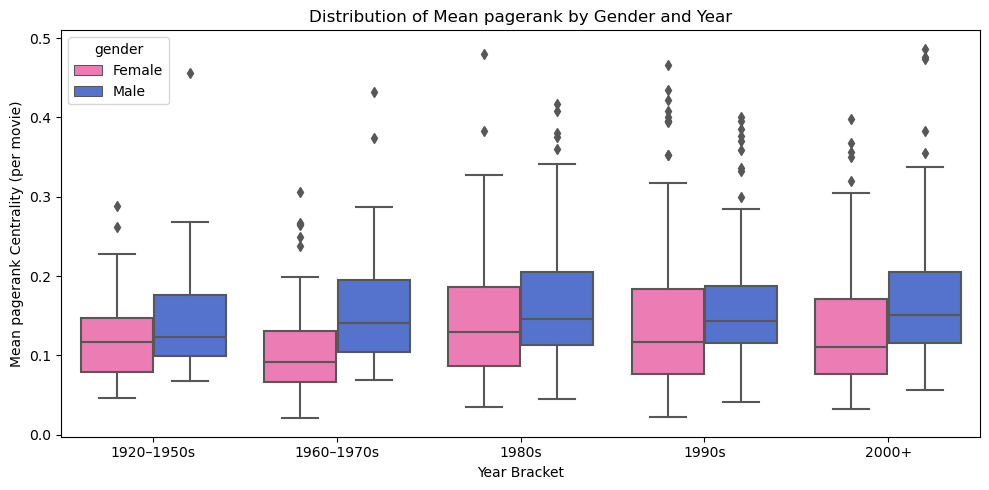

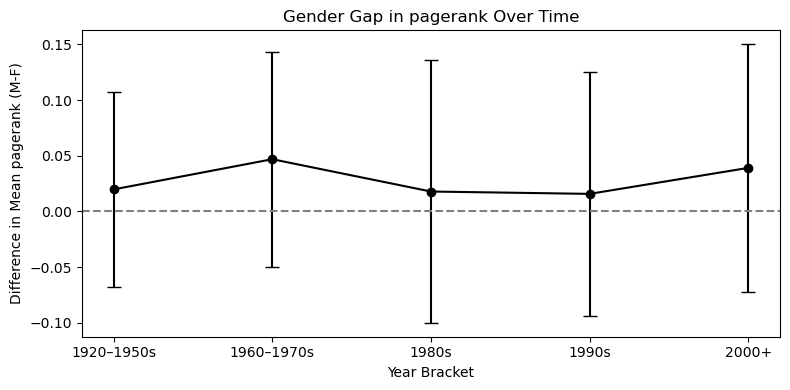

In [78]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']

for met in metrics:
    male_female_year_comp(met)

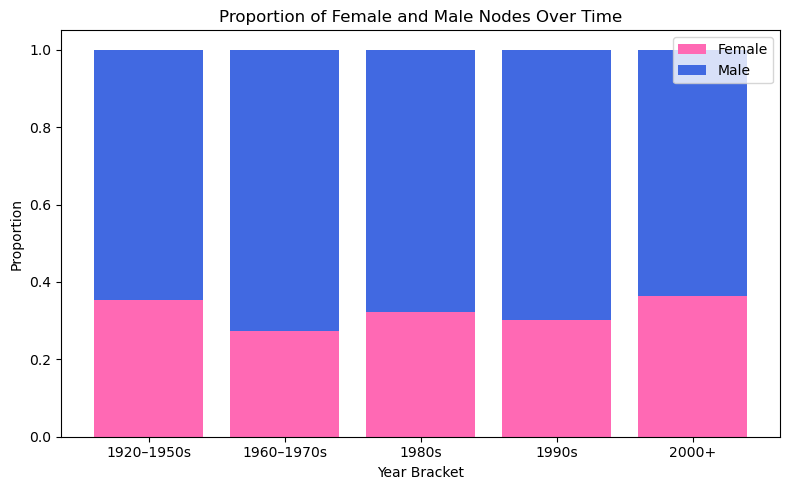

In [71]:
by_year = df_metrics.groupby('year_bracket').agg({
    'n_female': 'sum',
    'n_male': 'sum',
    'pct_known_gender': 'mean'
}).reset_index()

by_year['total'] = by_year['n_female'] + by_year['n_male']
by_year['prop_female'] = by_year['n_female'] / by_year['total']
by_year['prop_male'] = by_year['n_male'] / by_year['total']

plt.figure(figsize=(8,5))
plt.bar(by_year['year_bracket'], by_year['prop_female'], label='Female', color='hotpink')
plt.bar(by_year['year_bracket'], by_year['prop_male'], bottom=by_year['prop_female'], label='Male', color='royalblue')
plt.xlabel('Year Bracket')
plt.ylabel('Proportion')
plt.title('Proportion of Female and Male Nodes Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
centrality_cols = [
    'top_degree_gender',
    'top_unw_degree_gender',
    'top_betweenness_gender',
    'top_pagerank_gender',
    'top_closeness_gender',
    'top_clustering_gender'
]

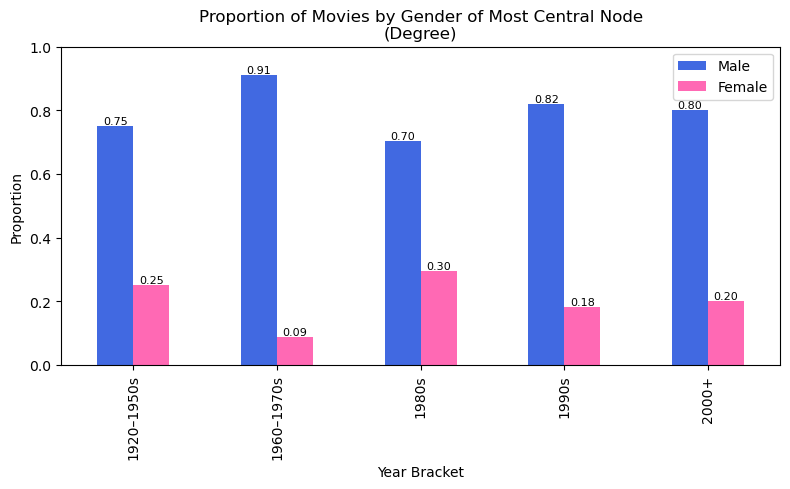

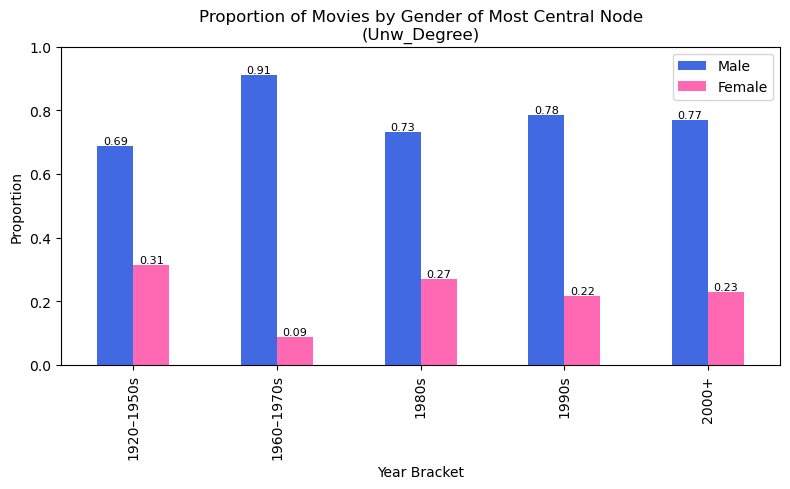

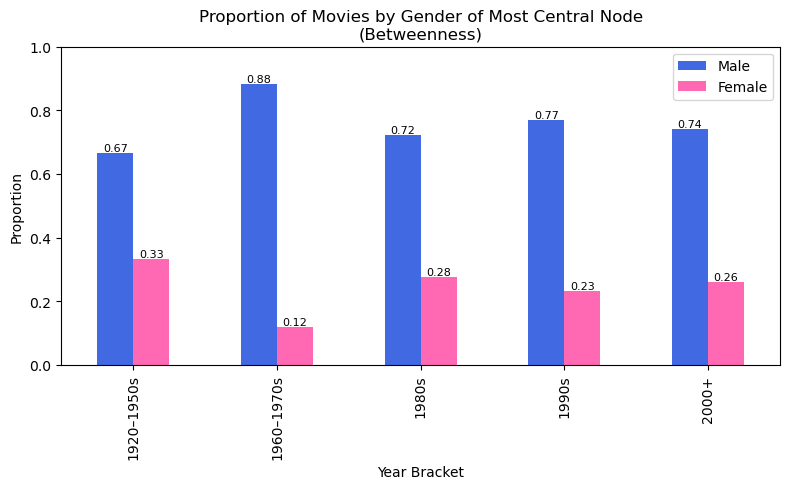

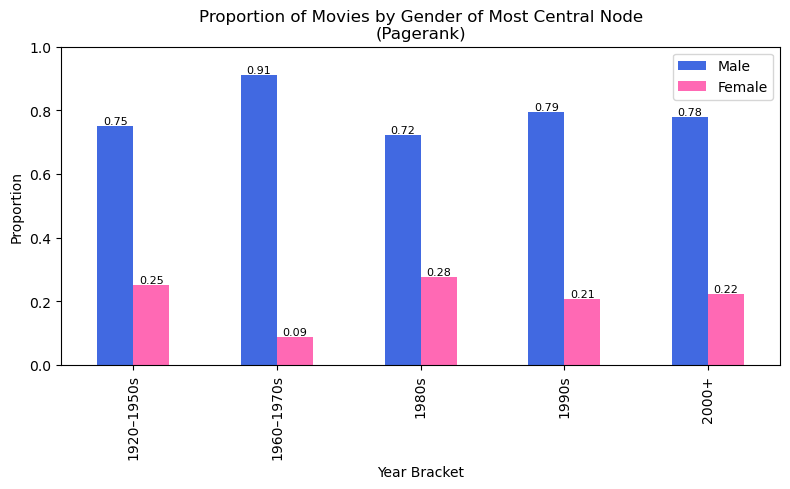

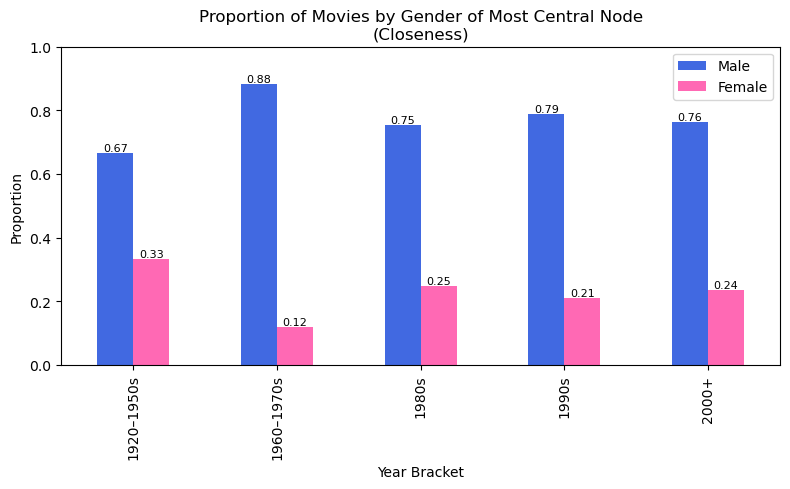

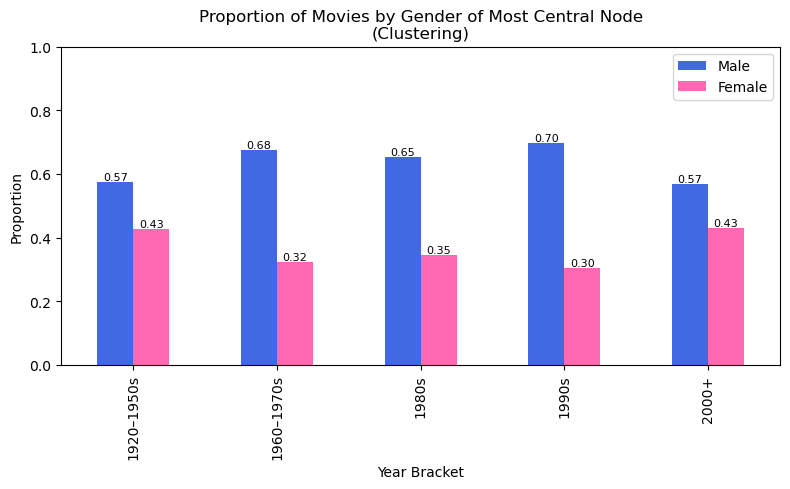

In [75]:
import numpy as np

for col in centrality_cols:
    gender_counts = (
        df_metrics.groupby(['year_bracket', col])
        .size()
        .unstack(fill_value=0)[['m', 'f']]
    )
    prop = gender_counts.div(gender_counts.sum(axis=1), axis=0)
    ax = prop.plot(kind='bar', figsize=(8,5), color=['royalblue','hotpink'])
    plt.title(f"Proportion of Movies by Gender of Most Central Node\n({col.replace('top_','').replace('_gender','').title()})")
    plt.xlabel('Year Bracket')
    plt.ylabel('Proportion')
    plt.ylim(0,1)
    plt.legend(['Male','Female'], loc='upper right')
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()


### Genre Analysis

In [80]:
main_genres = [
    'drama', 'thriller', 'action', 'comedy', 'crime', 'romance',
    'sci-fi', 'adventure', 'mystery', 'horror', 'fantasy'
]


In [124]:
genre_col = 'genres' if 'genres' in df_metrics.columns else 'genre'

df_metrics[genre_col] = df_metrics[genre_col].apply(lambda x: x if isinstance(x, list) else eval(x))

df_exploded = df_metrics.explode(genre_col)
df_exploded = df_exploded.rename(columns={genre_col: 'genre'})

df_main_genres = df_exploded[df_exploded['genre'].isin(main_genres)].copy()

In [146]:
def male_female_genre_comp(df, metric, genre_order):
    grouped = (
        df
        .groupby('genre')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )

    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()

    grouped = grouped.set_index('genre').reindex(genre_order).reset_index()

    plt.figure(figsize=(10,5))
    df_long = df.melt(id_vars=['genre'],
                             value_vars=[f'{metric}_f_mean',f'{metric}_m_mean'],
                             var_name='gender', value_name=f'mean_{metric}')
    df_long['gender'] = df_long['gender'].map({f'{metric}_f_mean':'Female',f'{metric}_m_mean':'Male'})

    sns.boxplot(
        x='genre',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=genre_order
    )
    plt.xlabel('Genre')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender and Year')
    plt.tight_layout()
    plt.show()


    diff = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    err = np.sqrt(grouped[f'{metric}_m_mean_std']**2 + grouped[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(8,4))
    plt.errorbar(grouped['genre'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Genre')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} Over Time')
    plt.tight_layout()
    plt.show()

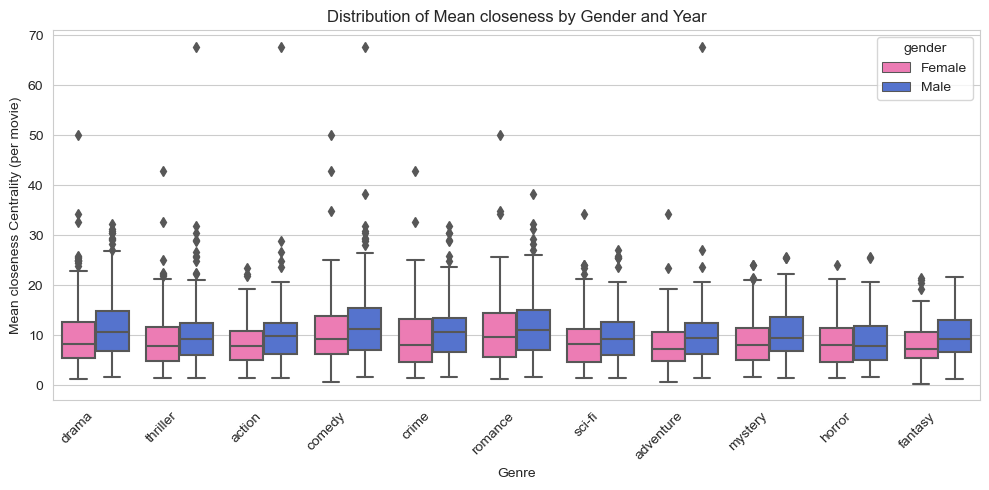

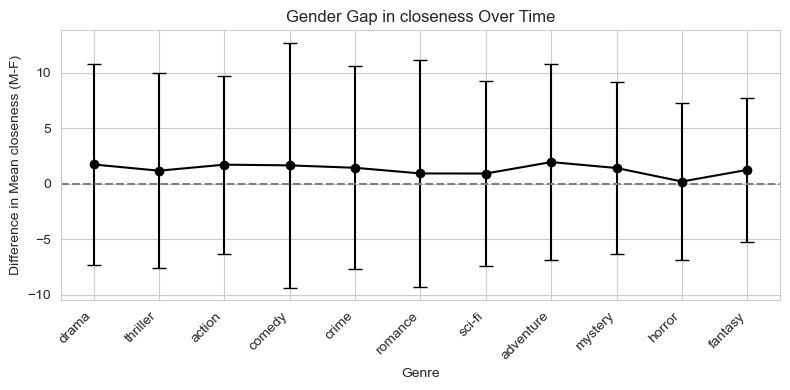

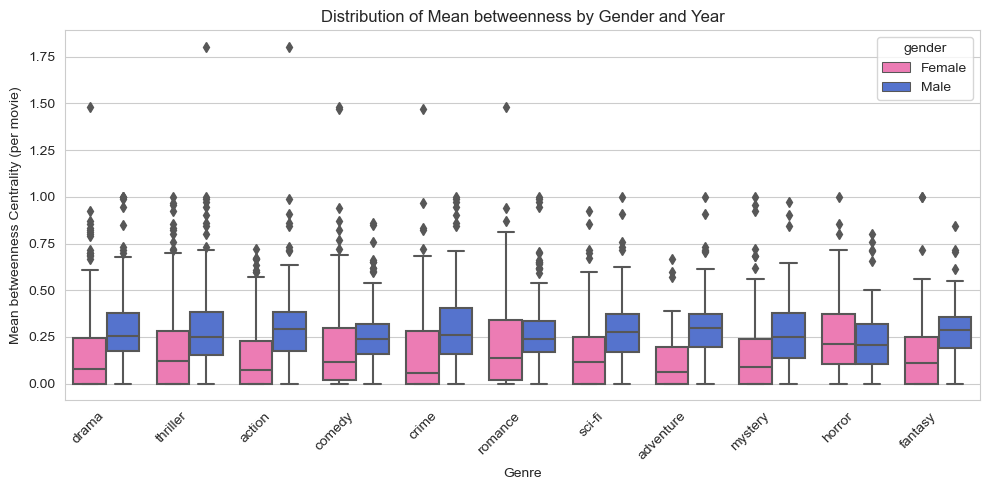

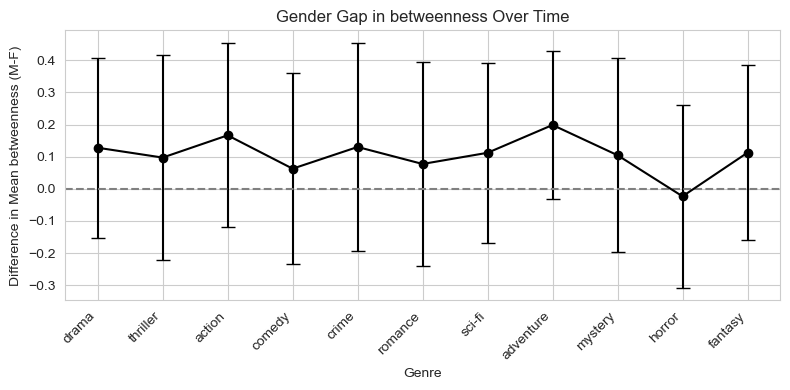

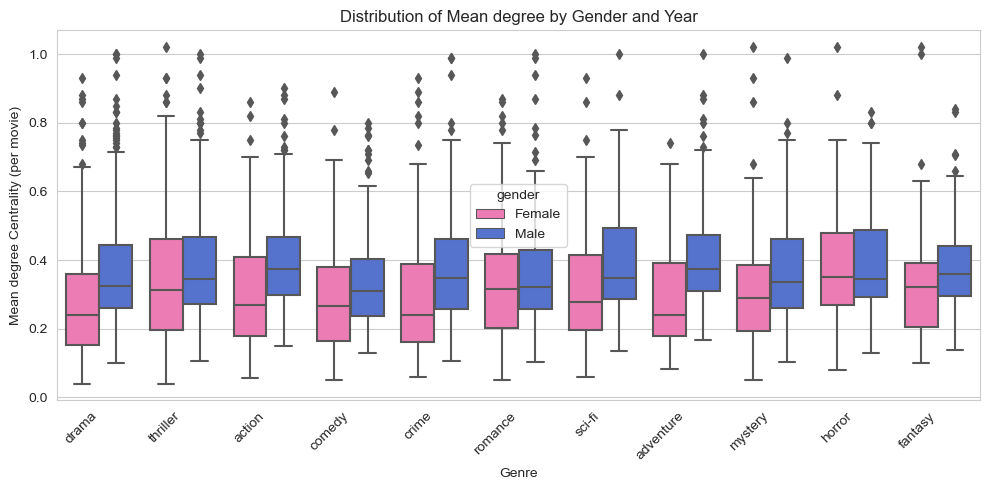

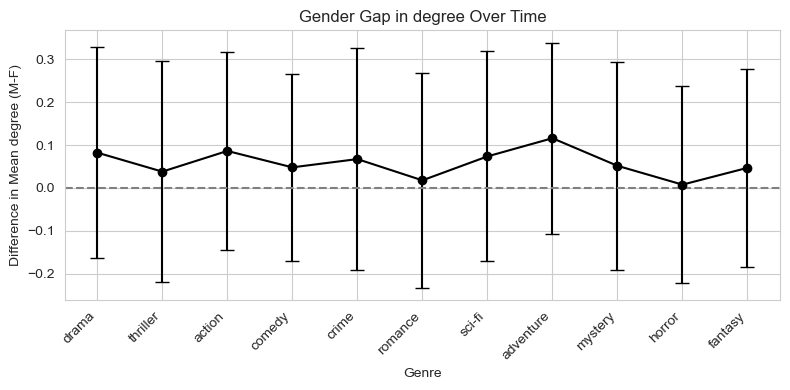

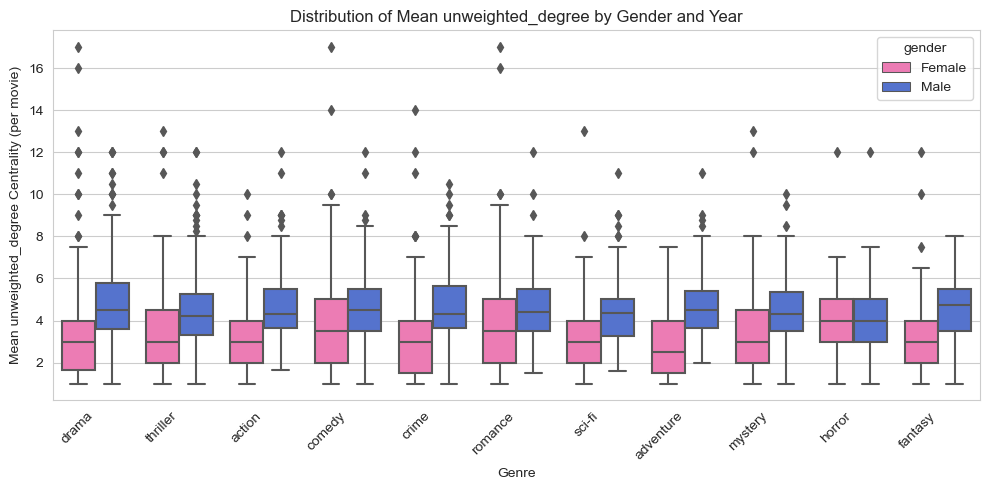

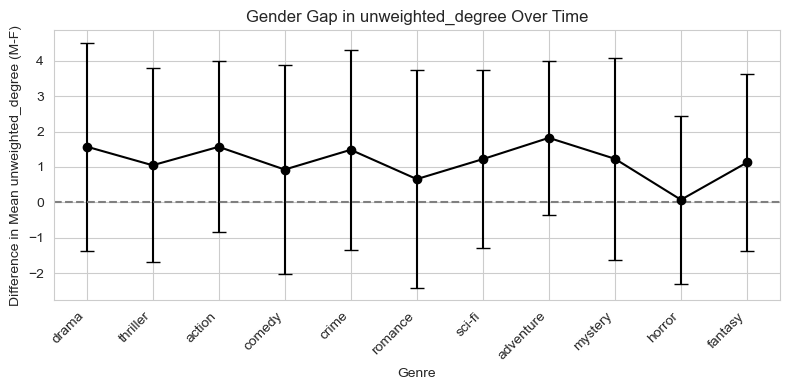

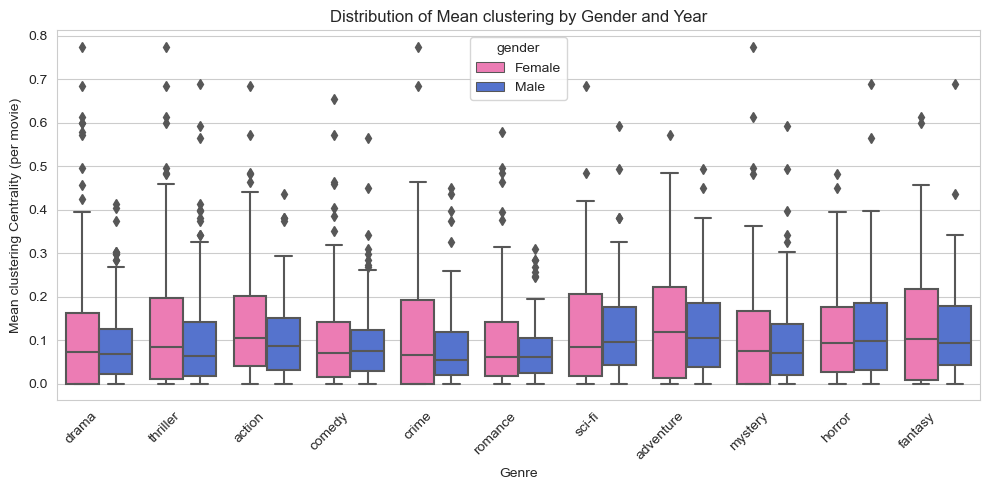

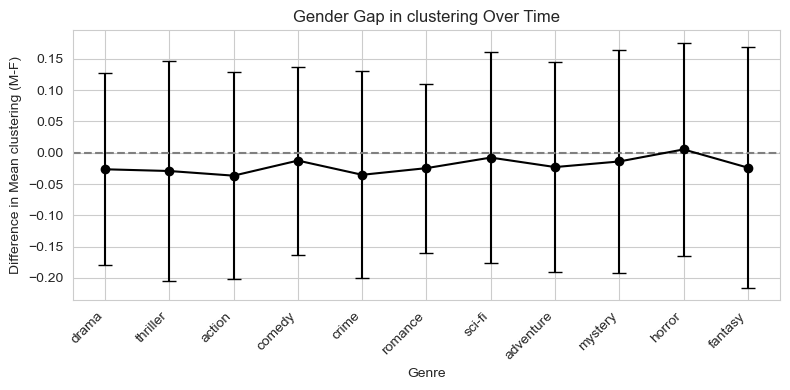

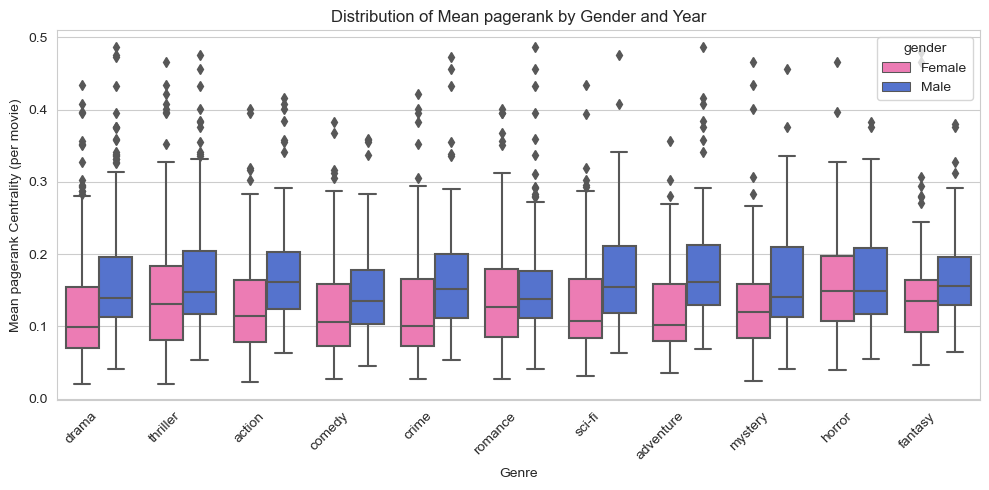

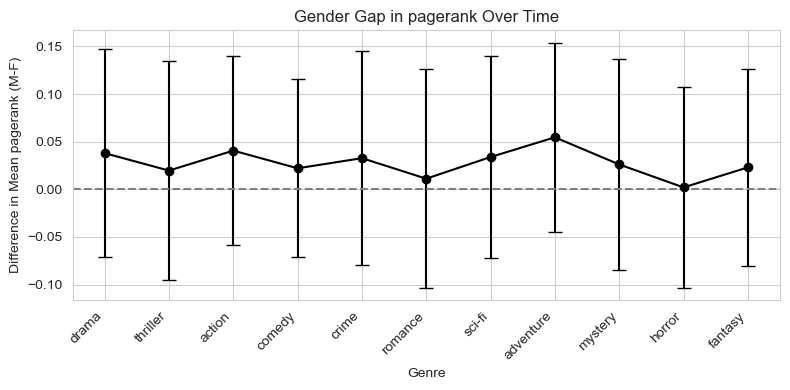

In [147]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']
base_genre_order = ['drama', 'thriller', 'action', 'comedy', 'crime', 'romance','sci-fi',
                                            'adventure', 'mystery', 'horror', 'fantasy']
for met in metrics:
    male_female_genre_comp(df_main_genres, met, genre_order = base_genre_order)

In [148]:
df_metrics['genre_combo'] = df_metrics['genres'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, list) else x)

top_combos = (
    df_metrics['genre_combo']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

In [162]:
df_top_combos = df_metrics[df_metrics['genre_combo'].isin(top_combos)].copy()
df_top_combos = df_top_combos.rename(columns={'genre_combo': 'genre'})

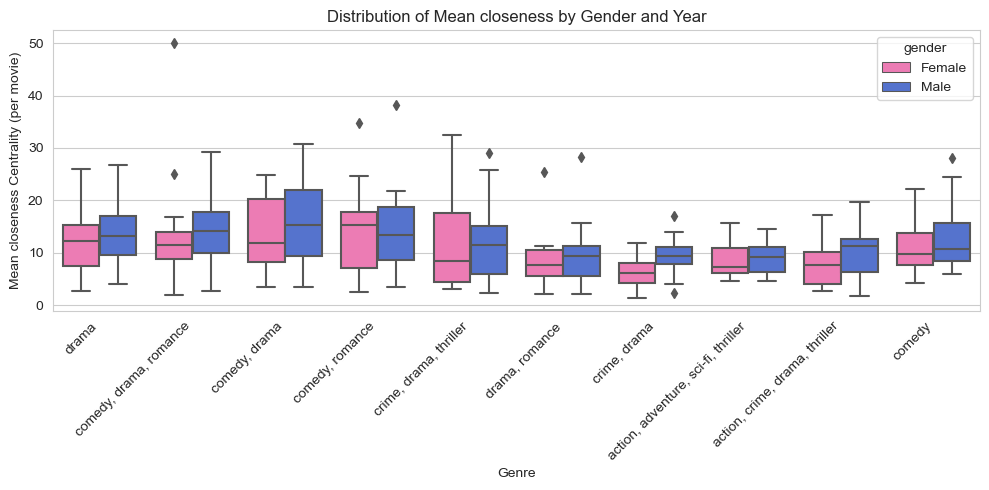

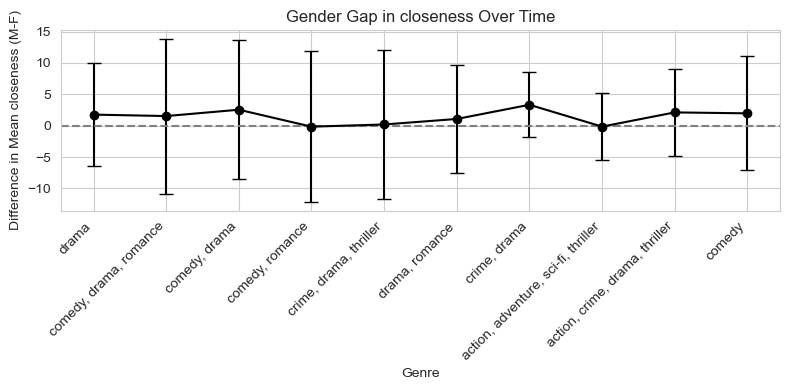

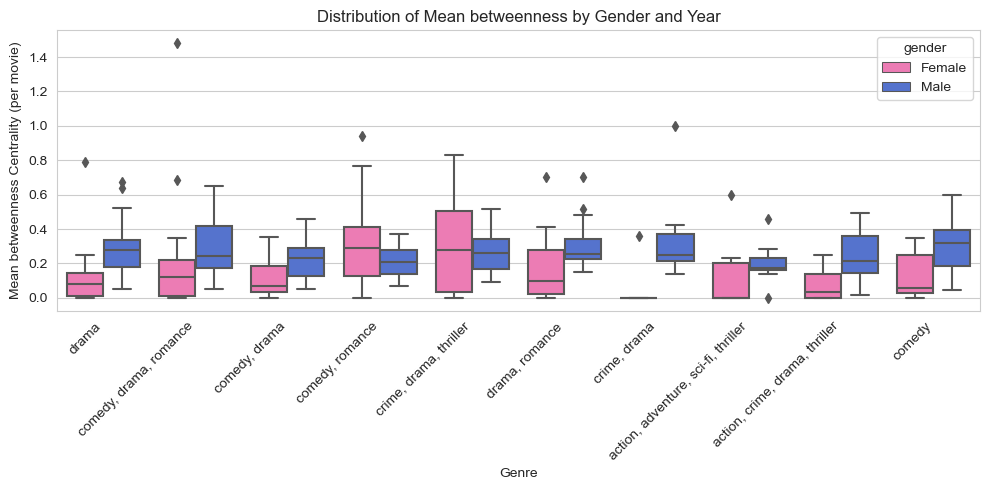

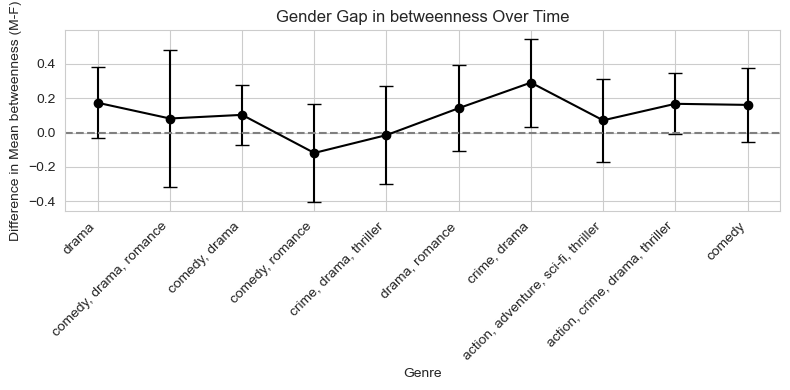

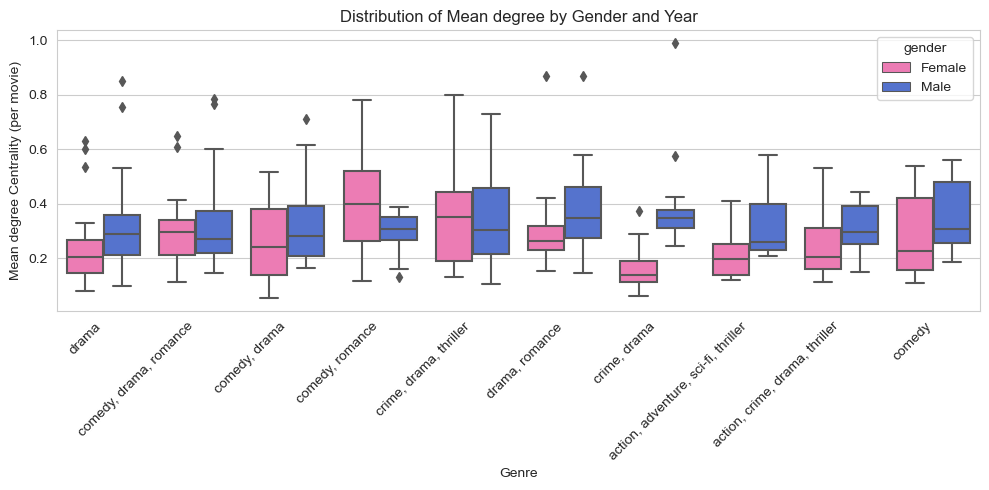

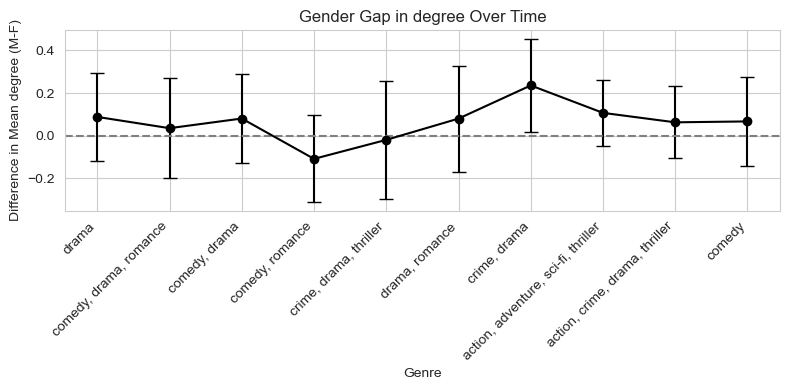

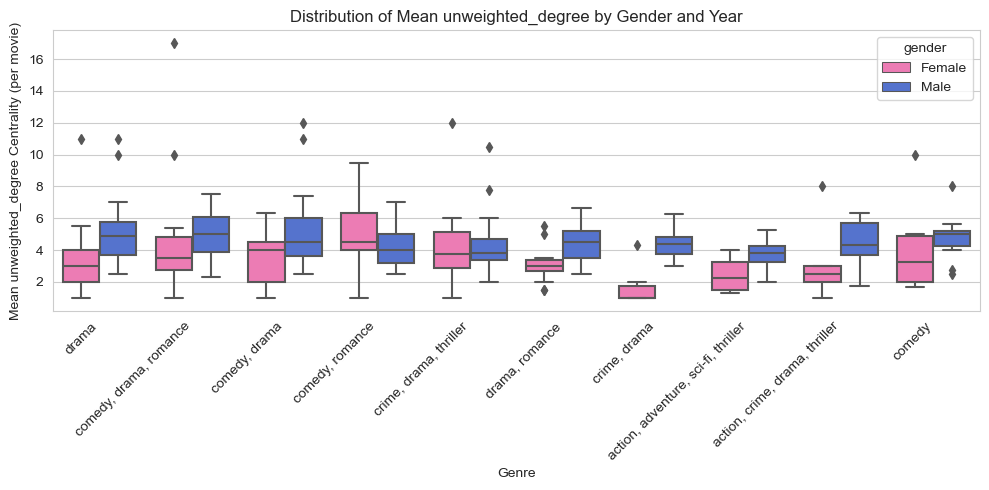

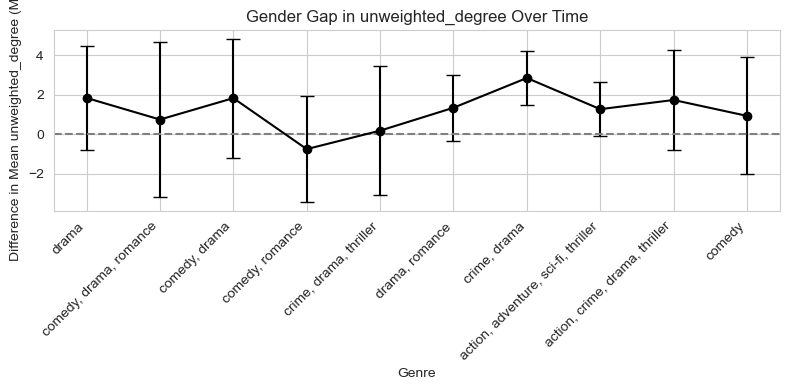

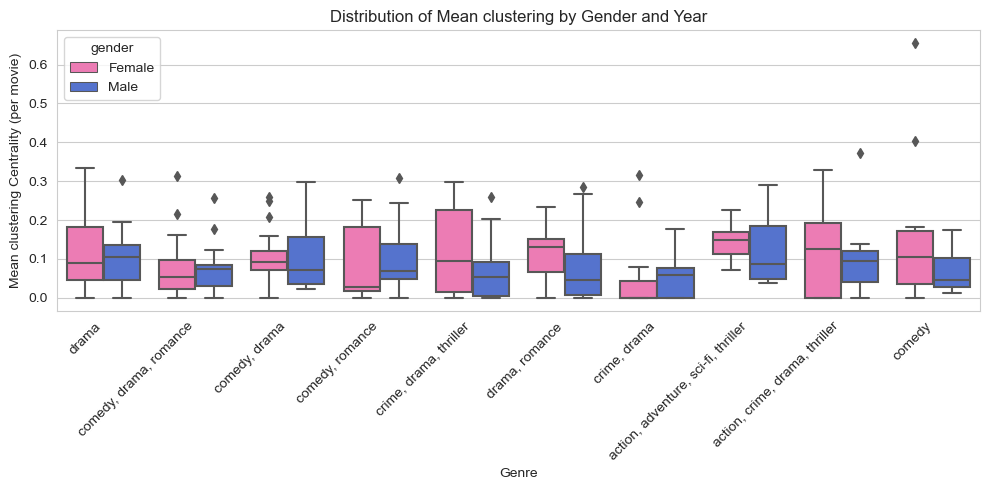

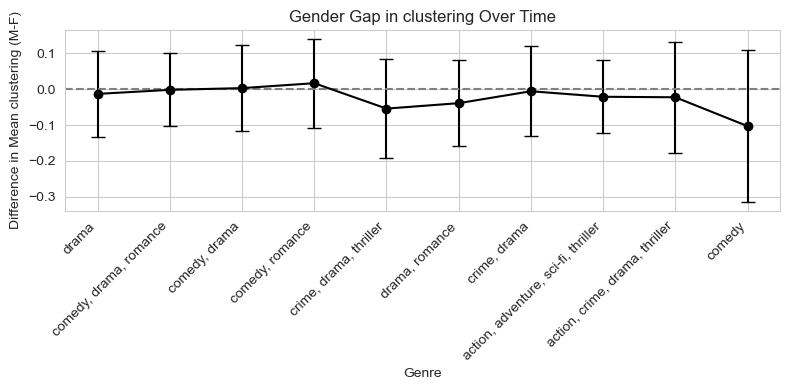

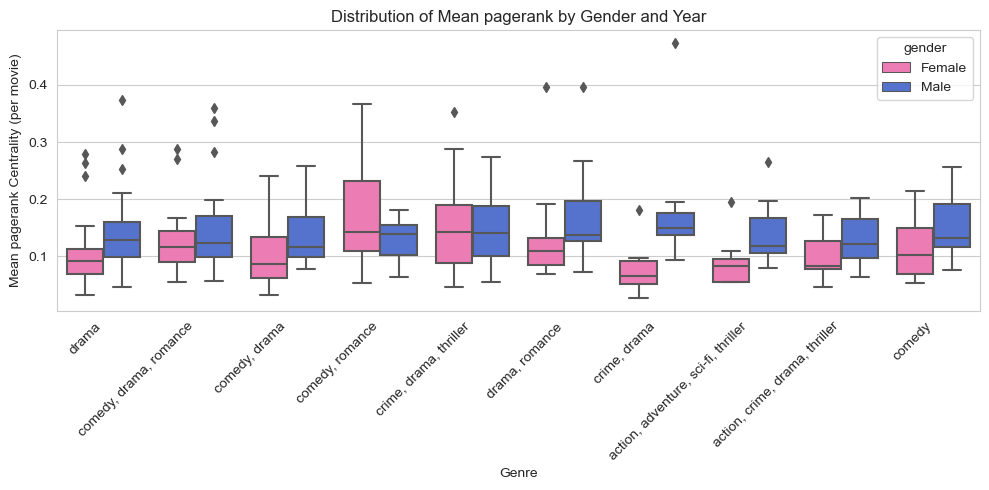

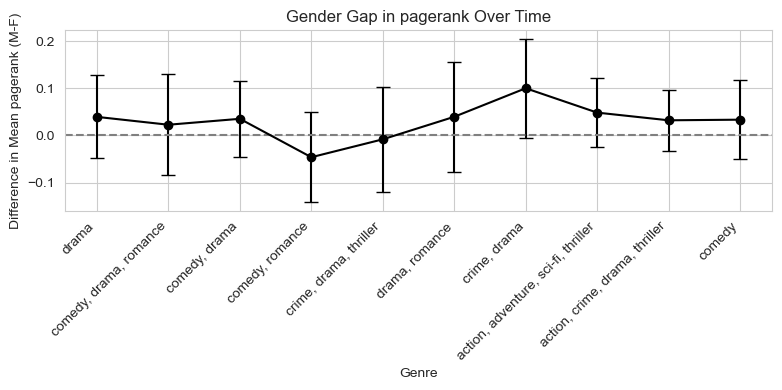

In [151]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']

for met in metrics:
    male_female_genre_comp(df_top_combos, met, genre_order = top_combos)

In [177]:
def male_female_extreme_genre_combos(df, metric):
    # Prepare genre_combo field
    if 'genre_combo' not in df.columns or 'genres_list' not in df.columns:
        df = df.copy()
        df['genres_list'] = df['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
        df['genre_combo'] = df['genres_list'].apply(lambda x: ', '.join(sorted(x)))

    df = df[df['genres_list'].apply(lambda x: len(x) <= 2)]

    # Group and calculate mean gap and count for each combo
    grouped = (
        df.groupby('genre_combo')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )
    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()
    grouped['gap'] = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    # Total movie count for combo (use female count; either is fine since each row is one movie)
    grouped['n_movies'] = grouped[[f'{metric}_f_mean_count', f'{metric}_m_mean_count']].max(axis=1)

    # Keep only combos with at least 2 movies
    grouped = grouped[grouped['n_movies'] >= 2]

    # Find 5 highest and 5 lowest gap combos
    top5 = grouped.sort_values('gap', ascending=False).head(5)
    bottom5 = grouped.sort_values('gap', ascending=True).head(5)
    selected = pd.concat([top5, bottom5])
    combo_order = selected['genre_combo'].tolist()

    # Long format for boxplot
    df_selected = df[df['genre_combo'].isin(combo_order)].copy()
    df_long = df_selected.melt(
        id_vars=['genre_combo'],
        value_vars=[f'{metric}_f_mean', f'{metric}_m_mean'],
        var_name='gender', value_name=f'mean_{metric}'
    )
    df_long['gender'] = df_long['gender'].map({
        f'{metric}_f_mean': 'Female',
        f'{metric}_m_mean': 'Male'
    })

    # Boxplot
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(14,5))
    sns.boxplot(
        x='genre_combo',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=combo_order
    )
    plt.xlabel('Genre Combination')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender\nTop 5 and Bottom 5 Genre Gaps (min 2 movies)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Errorbar plot for mean gaps
    selected = selected.set_index('genre_combo').reindex(combo_order).reset_index()
    diff = selected[f'{metric}_m_mean_mean'] - selected[f'{metric}_f_mean_mean']
    err = np.sqrt(selected[f'{metric}_m_mean_std']**2 + selected[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(14,4))
    plt.errorbar(selected['genre_combo'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Genre Combination')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} (Top 5 and Bottom 5 Genre Combos, min 2 movies)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



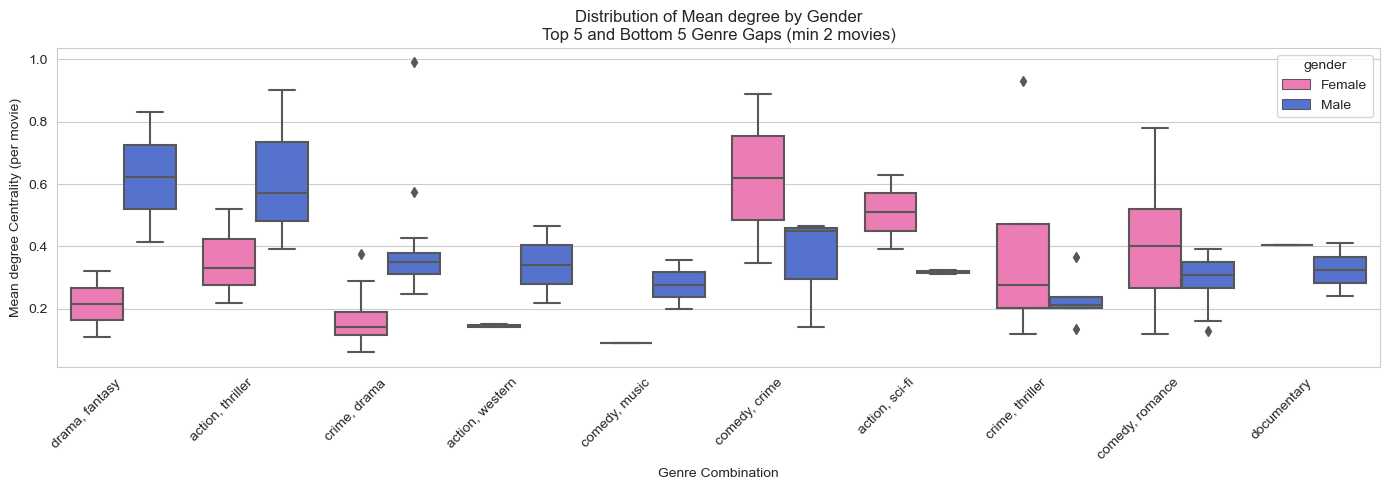

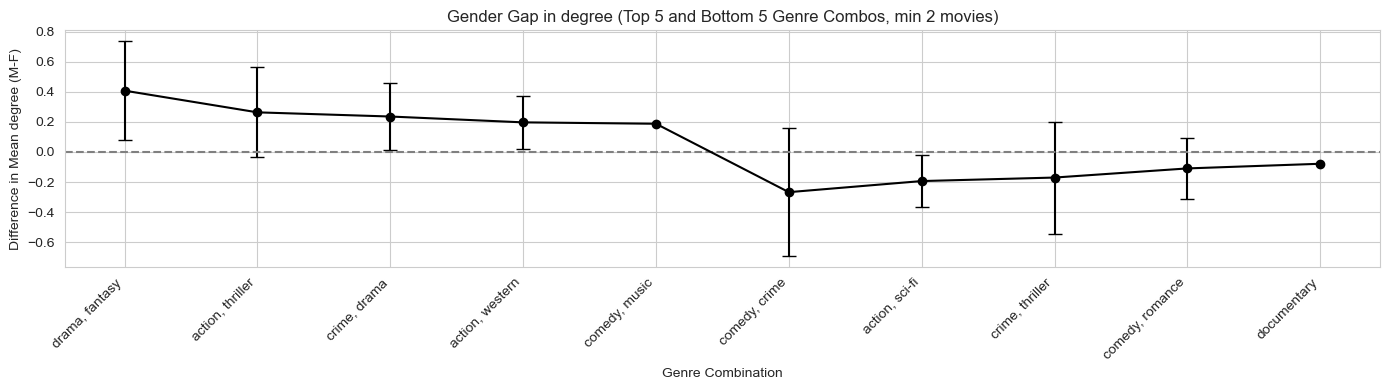

In [178]:
male_female_extreme_genre_combos(df_metrics, 'degree')